### Imports

In [1]:
import os
import gc
import glob
import json
from collections import defaultdict
import multiprocessing as mp
from pathlib import Path
from types import SimpleNamespace
from typing import Dict, List, Optional, Tuple
import warnings
from importlib import reload
import random

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas
import PIL.Image as Image
# disable PIL.DecompressionBombWarning
Image.MAX_IMAGE_PIXELS = None

from sklearn.metrics import fbeta_score
from sklearn.exceptions import UndefinedMetricWarning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from tqdm.auto import tqdm
warnings.simplefilter('ignore', UndefinedMetricWarning)

import utils

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

2023-06-03 15:21:25.997070: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-03 15:21:26.026381: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-03 15:21:26.465193: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


cuda


### Set up data

Today we'll work with a smaller dataset: a random selection of 4 rectangular pieces from each fragment.

Fragment 1 indices: 8,1, 11,1, 4,8, 7,2


Loading fragment from data/pieces/train/1/8,1:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/11,1:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/4,8:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/1/7,2:   0%|          | 0/32 [00:00<?, ?it/s]

Fragment 2 indices: 0,3, 5,3, 12,12, 7,4


Loading fragment from data/pieces/train/2/0,3:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/5,3:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/12,12:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/2/7,4:   0%|          | 0/32 [00:00<?, ?it/s]

Fragment 3 indices: 2,2, 4,2, 3,8, 1,3


Loading fragment from data/pieces/train/3/2,2:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/4,2:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/3,8:   0%|          | 0/32 [00:00<?, ?it/s]

Loading fragment from data/pieces/train/3/1,3:   0%|          | 0/32 [00:00<?, ?it/s]

14799 training items, 3700 validation items


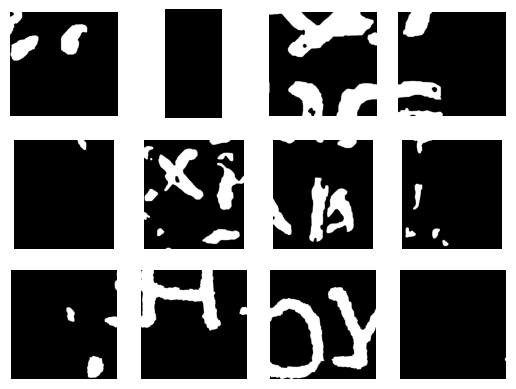

In [2]:
from sklearn.model_selection import train_test_split

BUFFER = 30  # Buffer size in x and y direction
Z_START = 16 # First slice in the z direction to use
Z_DIM = 32   # Number of slices in the z direction

# Define dataset
PREFIX = Path('data/pieces/train/')
dsets = []
for fragment in range(1, 4):
    # read the list of indices
    with open(PREFIX/str(fragment)/'pairs.txt', 'r') as f:
        indices = f.read().split("\n")
    random.seed(28)
    indices_to_use = random.choices(indices, k=4)
    print(f"Fragment {fragment} indices: {', '.join(indices_to_use)}")
    for i, index in enumerate(indices_to_use):
        dsets.append(utils.get_rect_dset(PREFIX/str(fragment)/index, Z_START, Z_DIM, BUFFER))
        # show fragments
        plt.subplot(3, 4, 4*(fragment-1)+i+1)
        plt.imshow(Image.open(PREFIX/str(fragment)/index/'inklabels.png'), cmap='gray')
        plt.axis('off')
full_dset = data.ConcatDataset(dsets)

# Split into training and validation
train_dset, val_dset = train_test_split(full_dset, test_size=0.2, random_state=4)
print(f"{len(train_dset)} training items, {len(val_dset)} validation items")

In [3]:
# define model
class InkDetector(torch.nn.Module):
    def __init__(self):
        super().__init__()

        filters = [16, 32, 64]
        paddings = [1, 1, 1]
        kernel_sizes = [3, 3, 3]
        strides = [2, 2, 2]
        
        layers = []
        in_channels = 1
        for num_filters, padding, kernel_size, stride in zip(filters, paddings, kernel_sizes, strides):
            layers.extend([
                nn.Conv3d(
                    in_channels=in_channels,
                    out_channels=num_filters,
                    kernel_size=kernel_size,
                    stride=stride,
                    padding=padding,
                ),
                nn.ReLU(inplace=True),
                torch.nn.BatchNorm3d(num_features=num_filters)
            ])
            in_channels = num_filters
        layers.append(nn.AdaptiveAvgPool3d(1))
        layers.append(nn.Flatten())

        self.encoder = nn.Sequential(*layers)
        self.decoder = nn.Sequential(
            nn.Linear(in_channels, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        features = self.encoder(x)
        return self.decoder(features)

In [4]:
# define dataloaders
BATCH_SIZE = 32
torch.manual_seed(4)
train_loader = data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(val_dset, batch_size=BATCH_SIZE, shuffle=False)
print(f"{len(train_loader)} training batches, {len(val_loader)} validation batches")

463 training batches, 116 validation batches


### Learning rate range test
We now experiment with learning rates, using the learning rate range test described in [this paper](http://arxiv.org/abs/1506.01186). This test increases the learning rate linearly as training goes on, and plots learning rate vs. test loss. A good choice of learning rate is one where the test loss starts to level off.

Training:   0%|          | 0/60000 [00:00<?, ?it/s]

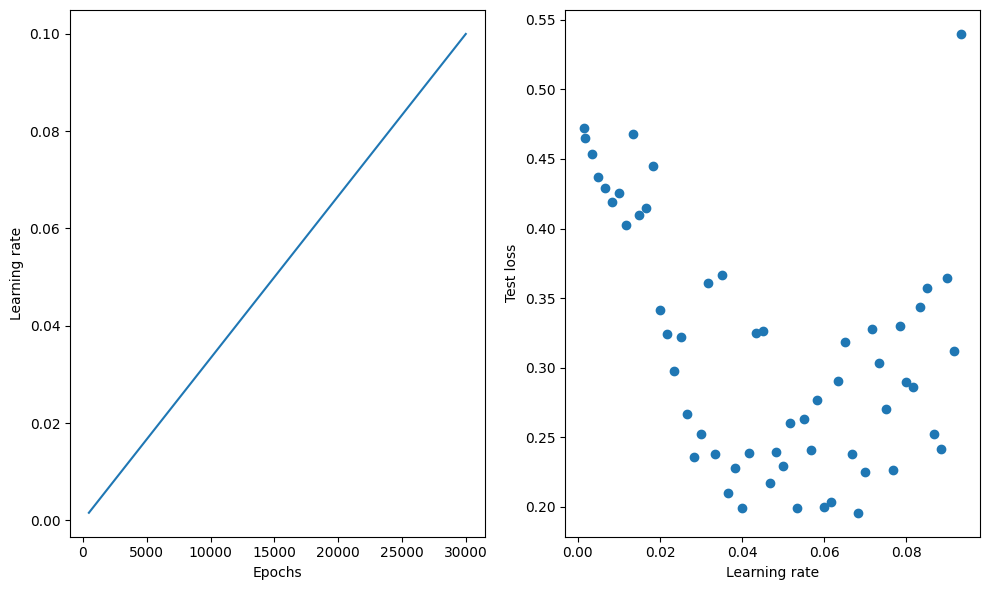

In [16]:
import utils.training
model = InkDetector().to(DEVICE)
TRAINING_EPOCHS = 30000 
VALIDATION_EPOCHS = 500
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD
scheduler = optim.lr_scheduler.CyclicLR
trainer = utils.Trainer(model, train_loader, val_loader,
                        optimizer=optimizer,
                        criterion=criterion,
                        lr=0.1,
                        scheduler=scheduler,
                        scheduler_base_lr=0.0,
                        scheduler_max_lr=0.1,
                        scheduler_step_size_up=TRAINING_EPOCHS, # only go up
                       )
trainer.train_eval_loop(TRAINING_EPOCHS, VALIDATION_EPOCHS)
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.plot(trainer.histories['epochs'], trainer.histories['lr'])
plt.gca().set(xlabel="Epochs", ylabel="Learning rate")
plt.subplot(122)
plt.scatter(trainer.histories['lr'], trainer.histories['val_loss'])
plt.gca().set(xlabel="Learning rate", ylabel="Test loss")
plt.tight_layout()

Great! It looks like the learning starts to level off around `lr=0.03` for this optimizer. Just for fun, let's also try out the Adam optimizer.

In [ ]:
model = InkDetector().to(DEVICE)
TRAINING_EPOCHS = 30000 
VALIDATION_EPOCHS = 500
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD
scheduler = optim.lr_scheduler.CyclicLR
trainer = utils.Trainer(model, train_loader, val_loader,
                        optimizer=optimizer,
                        criterion=criterion,
                        lr=0.1,
                        scheduler=scheduler,
                        scheduler_base_lr=0.0,
                        scheduler_max_lr=0.1,
                        scheduler_step_size_up=TRAINING_EPOCHS, # only go up
                       )
trainer.train_eval_loop(TRAINING_EPOCHS, VALIDATION_EPOCHS)


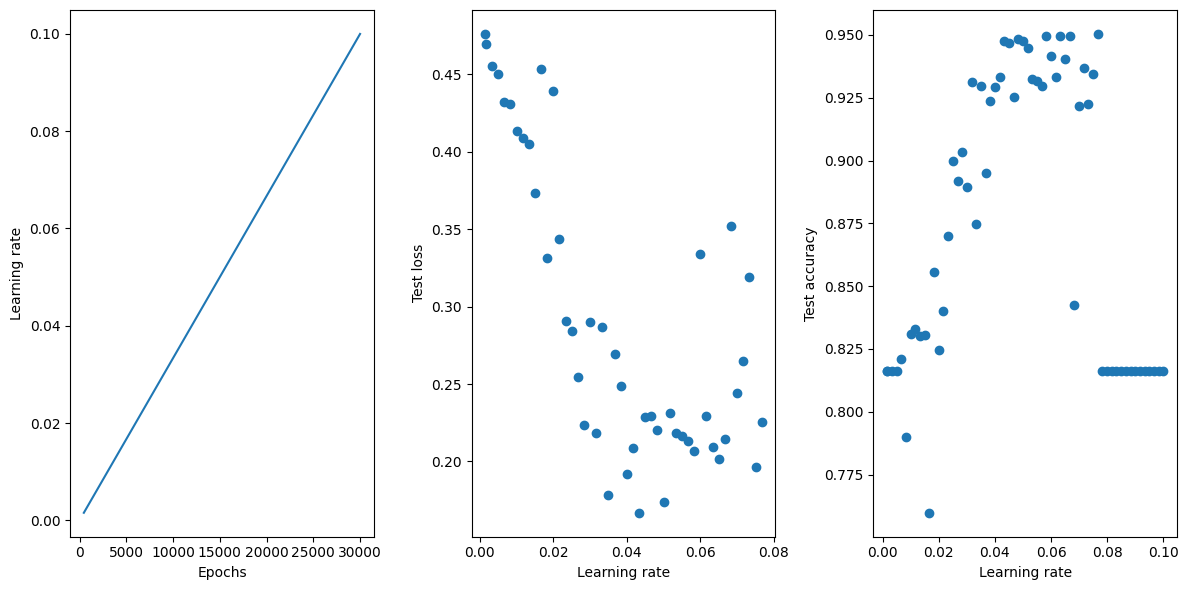

In [8]:
plt.figure(figsize=(12,6))
plt.subplot(131)
plt.plot(trainer.histories['epochs'], trainer.histories['lr'])
plt.gca().set(xlabel="Epochs", ylabel="Learning rate")
plt.subplot(132)
plt.scatter(trainer.histories['lr'], trainer.histories['val_loss'])
plt.gca().set(xlabel="Learning rate", ylabel="Test loss")
plt.subplot(133)
plt.scatter(trainer.histories['lr'], trainer.histories['val_acc'])
plt.gca().set(xlabel="Learning rate", ylabel="Test accuracy")
plt.tight_layout()

Again, it looks like the learning starts to peak around 0.03-0.04. Notice that at learning rate 0.75, the test accuracy collapses to a constant, suggesting that the model weights have either blown up or vanished.

### Experiments with training hyperparameters
The following attributes of the training setup could be tweaked:
- **Optimizer-scheduler:** SGD with constant learning rate, SGD with CyclicLR policy, SGD with OneCycleLR policy, Adam with constant learning rate
    - Learning rate scheduling apparently doesn't work as well with Adam, which internally is doing something like dynamically adjusting the learning rate
- **Batch size:** I'll do 8, 16, 32, 64.
- **Learning rate:** For the constant learning rate policies, I'll try 3e-3, 1e-2, and 3e-2.
- **Layers to use:** `Z_DIM` in {8, 16, 32}, `Z_START` in {0, 8, 16, 24, 32, 40, 48, 56}.
- **Buffer size:** We currently have 30 (so a 61x61 square). I'll also try 15.

There are a few modifications which I will hold off on for now, but mention here anyway.
- **Optimizer parameters:** If one optimizer setup is clearly better, we can then think about tweaking optimizer parameter such as momentum. I'd prefer to wait on this until I've seen how the optimizers perform at base.
- **Data augmentation:** With or without random reflections in the cardinal directions. This is less pressing because it's a strategy for preventing overfitting, which we don't yet have a problem with.
- **Regularization:** The first things that come to mind are weight decay and early stopping. Again, these are strategies for preventing overfitting.
- **Denoising the data:** By using the updated masks provided by Brett Olsen. I am skipping this because it would affect the dataset in a positionally-dependent way, and I'm just working with a small piece of the full dataset. To experiment with this, we should focus on pieces of the dataset around the places that differ between the two masks.
- **Multi-fragment training strategies:** Some way to deal with the observation that fragment 2 is very different than fragments 1 and 3 -- do we train longer on fragment 2? Do we ignore fragment 2 at first and see if we can attain generalization from fragment 1 to 3? Do we do some kind of normalization? I'm skipping this because I don't yet know how to experiment with it rigorously.

Now, the appropriate way to deal with a bunch of hyperparameters is to do a randomized or grid search. At this exploratory stage, I'm going to modify them one at a time. I hope this will give us a sense for which ones are useless and which ones have a noticeable effect. To start, let me establish a baseline -- the training setup we've been using -- that's capable of learning our small dataset.


In [12]:
import time
from utils import Trainer, create_writer
BATCH_SIZE = 32
LEARNING_RATE = 0.03
tic = time.perf_counter()
train_loader = data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(val_dset, batch_size=BATCH_SIZE, shuffle=False)
model = InkDetector().to(DEVICE)
MODEL_NAME = "InkDetector_small_dataset_base"
MODEL_SAVE_PATH = "trained_models/" + MODEL_NAME + ".pt"
TRAINING_EPOCHS = 30000 
VALIDATION_EPOCHS = 500
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD
scheduler = optim.lr_scheduler.OneCycleLR
writer = create_writer(model_name=MODEL_NAME)
trainer = Trainer(model, train_loader, val_loader,
                  optimizer=optimizer,
                  criterion=criterion,
                  lr=LEARNING_RATE,
                  scheduler=scheduler,
                  scheduler_total_steps=TRAINING_EPOCHS,
                  scheduler_max_lr=LEARNING_RATE,
                  writer=writer)

trainer.train_eval_loop(TRAINING_EPOCHS, VALIDATION_EPOCHS)

torch.save(model.state_dict(), MODEL_SAVE_PATH)
toc = time.perf_counter()
runtime = toc - tic
print(f"Finished in {runtime/60:.0f}m{runtime - 60*int(runtime/60):.0f}s")

# clean up
del model, train_loader, val_loader
    
    

Created SummaryWriter saving to logs/2023-06-03/InkDetector_small_dataset_base.


Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Finished in 9m13s


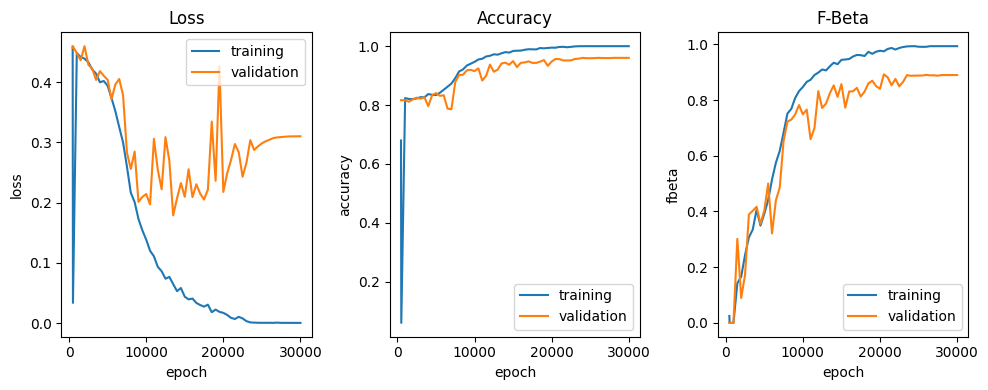

In [15]:
plt.figure(figsize=(10, 4))
trainer.plot_metrics()

This model reached accuracy = 1.0 on the training set. It begins to overfit aorund 9500 epoochs. It may be reasonable to try larger datasets and shorter training times.

I forgot to save the metric histories for this experiment, but the results were, to be brief, disappointing. (They can be seen in TensorBoard). All models got stuck at $F_{0.5} = 0$, which I assume means they predicted every pixel as negative. This includes the batch size 32 model, which was trained successfully before. This means that the model behavior is sensitive to initialization and to the data it ends up seeing. Next we should try to experiment with the optimizer and learning rate, to see if we can get these models unstuck.

After looking back at this, I realize that I switched optimizers from SGD to Adam... which I'd observed to not work with this setup before... ugh. Will try again.

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

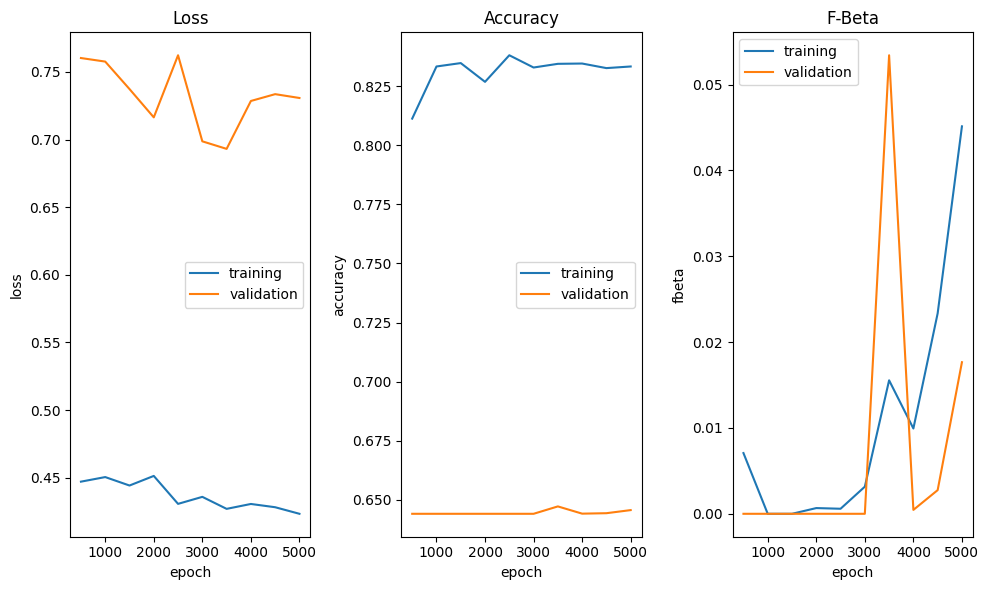

In [32]:
# Testing new kwargs capability
import utils
reload(utils.training)
from utils import Trainer
BATCH_SIZE = 32
train_loader = data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(val_dset, batch_size=BATCH_SIZE, shuffle=False)
model = InkDetector().to(DEVICE)
TRAINING_EPOCHS = 5000 * 32 // BATCH_SIZE
VALIDATION_EPOCHS = 500 * 32 // BATCH_SIZE
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD
scheduler = optim.lr_scheduler.OneCycleLR
trainer = Trainer(model, train_loader, val_loader,
                  optimizer=optimizer,
                  criterion=criterion,
                  lr=LEARNING_RATE,
                  scheduler=scheduler,
                  optimizer_momentum=0.9,
                  scheduler_div_factor=5)
trainer.train_eval_loop(5000, 500)
plt.figure(figsize=(10,6))
trainer.plot_metrics()

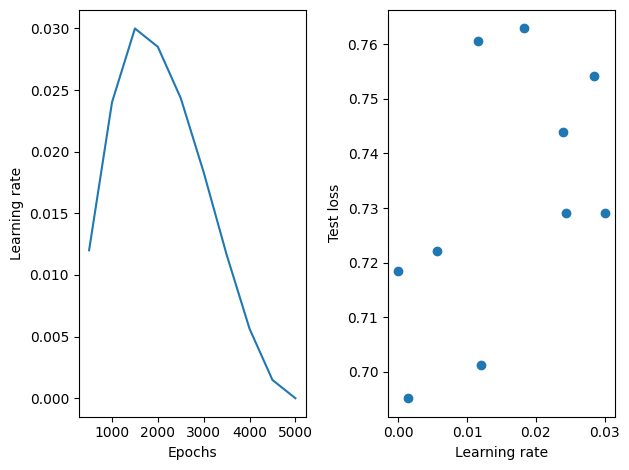

In [25]:
# view learning rate
plt.subplot(121)
plt.plot(trainer.histories['epochs'], trainer.histories['lr'])
plt.gca().set(xlabel="Epochs", ylabel="Learning rate")
plt.subplot(122)
plt.scatter(trainer.histories['lr'], trainer.histories['val_loss'])
plt.gca().set(xlabel="Learning rate", ylabel="Test loss")
plt.tight_layout()

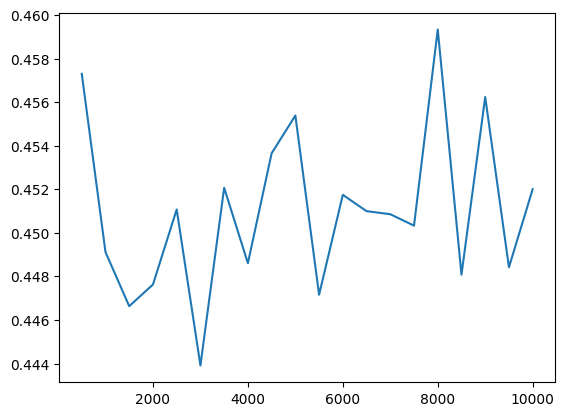

In [39]:
plt.plot(trainer.histories['epochs'], trainer.histories['train_loss'])

In [35]:
trainer.histories['train_loss']

[0.4607077481150627,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

### Experiment with optimizers

In [13]:
from utils import Trainer, create_writer
TRAINING_EPOCHS = 60000
MODEL_NAME = "InkDetector_all_fragments_60k_epochs_Adam"
MODEL_SAVE_PATH = "trained_models/" + MODEL_NAME + ".pt"
if TRAIN_RUN:
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam
    scheduler = optim.lr_scheduler.OneCycleLR
    
    # log to tensorboard
    writer = create_writer(model_name=MODEL_NAME)
    trainer = Trainer(model, train_loader, val_loader,
                      optimizer=optimizer,
                      criterion=criterion,
                      lr=LEARNING_RATE,
                      scheduler=scheduler,
                      writer=writer)
    
    trainer.train_eval_loop(TRAINING_EPOCHS, VALIDATION_EPOCHS)
    
    torch.save(model.state_dict(), MODEL_SAVE_PATH)

else:
    model_weights = torch.load(MODEL_SAVE_PATH)
    model.load_state_dict(model_weights)

Created SummaryWriter saving to logs/2023-05-25/InkDetector_all_fragments_60k_epochs_Adam.


Training:   0%|          | 0/60000 [00:00<?, ?it/s]

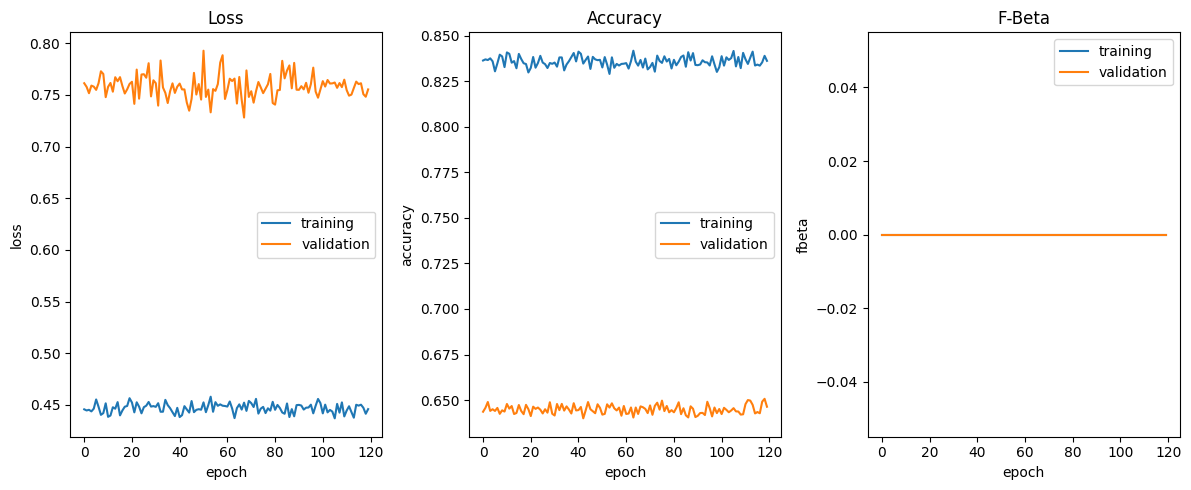

In [14]:
if TRAIN_RUN:
    plt.figure(figsize=(12, 5))
    trainer.plot_metrics()

Observation: it didn't train! Will have to double-check that SGD still works, and if it does, try Adam with other learning rates.

In [ ]:
from utils import predict_validation_rects

fig = predict_validation_rects(model,
                               fragments_to_use=[1,2,3],
                               data_path=BASE_PREFIX,
                               z_start=Z_START,
                               z_dim=Z_DIM,
                               buffer=BUFFER,
                               validation_rects=VALIDATION_RECTS,
                               writer=writer)

In [ ]:
# show the figure (a little annoying: see this link--)
# https://stackoverflow.com/questions/49503869/attributeerror-while-trying-to-load-the-pickled-matplotlib-figure
dummy = plt.figure()
new_manager = dummy.canvas.manager
new_manager.canvas.figure = fig
fig.set_canvas(new_manager.canvas)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs --port 6004

**Question:** On fragments 1 and 3, the letter shape is at least recognizable, but not on fragment 2. Any idea why that would be?

#### Clean up before testing

In [ ]:
print([x for x in dir() if not x.startswith('_')])

In [ ]:
# Clear memory before loading test fragments
to_delete = [
    'image_stack',
    'train_dset',
    'train_dsets',
    'train_loader',
    'val_dset',
    'val_dsets',
    'val_loader'
]
for name in to_delete:
    if name in dir():
        exec('del ' + name)
gc.collect()

#### Testing

In [ ]:
test_path = Path(BASE_PREFIX) / "test"
test_fragments = [p.stem for p in test_path.iterdir()]
print("All fragments:", test_fragments)

In [ ]:
import utils
reload(utils)
reload(utils.data_preparation)
reload(utils)

In [ ]:
# Predict on test fragments
from utils.data_preparation import get_rect_dset
DECISION_BOUNDARY = 0.4

pred_images = []
model.eval()
for test_fragment in test_fragments:
    outputs = []
    test_dset = get_rect_dset(test_fragment, BASE_PREFIX, z_start=Z_START,
                              z_dim=Z_DIM, buffer=BUFFER)
    test_loader = data.DataLoader(test_dset, batch_size=BATCH_SIZE, shuffle=False)
    with torch.no_grad():
        for i, (subvolumes, _) in enumerate(tqdm(test_loader, desc=f"Predicting on fragment {test_fragment}"):
            output = model(subvolumes.to(DEVICE)).view(-1).sigmoid().cpu().numpy()
            outputs.append(output)
    image_shape = eval_dset.image_stack[0].shape
    
    # clean up
    test_dset.image_stack = None
    del test_loader
    gc.collect()

    pred_image = np.zeros(image_shape, dtype=np.uint8)
    outputs = np.concatenate(outputs)
    for (y, x, _), prob in zip(test_dset.pixels[:outputs.shape[0]], outputs):
        pred_image[y, x] = prob > DECISION_BOUNDARY
    pred_images.append(pred_image)
    
    eval_dset.pixels = None
    del eval_dset
    gc.collect()
    print("Finished with fragment", test_fragment)

### Submission

In [ ]:
def rle(output):
    flat_img = np.where(output > 0.4, 1, 0).astype(np.uint8)
    starts = np.array((flat_img[:-1] == 0) & (flat_img[1:] == 1))
    ends = np.array((flat_img[:-1] == 1) & (flat_img[1:] == 0))
    starts_ix = np.where(starts)[0] + 2
    ends_ix = np.where(ends)[0] + 2
    lengths = ends_ix - starts_ix
    return " ".join(map(str, sum(zip(starts_ix, lengths), ())))

In [ ]:
submission = defaultdict(list)
for fragment_id, fragment_name in enumerate(test_fragments):
    submission["Id"].append(fragment_name.name)
    submission["Predicted"].append(rle(pred_images[fragment_id]))


In [ ]:
pd.DataFrame.from_dict(submission).to_csv("/kaggle/working/submission.csv", index=False)
pd.DataFrame.from_dict(submission)